In [3]:
#perfect cases
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import math

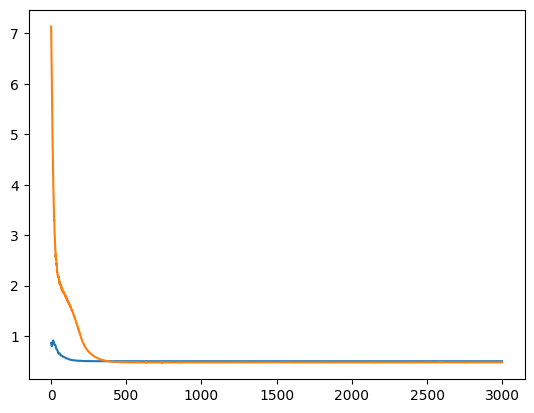

In [181]:
X_og = np.concatenate([np.random.normal(5,1,1000)])
X = torch.tensor(X_og)

class SingleN(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = nn.Parameter(torch.tensor(0.2))
        self.b = nn.Parameter(torch.tensor(0.2))
        self.c = nn.Parameter(torch.tensor(0.2))
        self.d = nn.Parameter(torch.tensor(0.2))
    def forward(self,x):
        return self.c*F.relu(self.a*x +self.b)+self.d

class model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers= nn.ModuleList([SingleN() for _ in range(3)])
    def forward(self,x):
        for l in self.layers:
            x += l(x)
        return x


model_q_mu = SingleN()
model_q_sigma = SingleN()
model_p_mu = SingleN()
model_p_sigma = SingleN()

optimiser = torch.optim.Adam(list(model_q_mu.parameters())+list(model_q_sigma.parameters())+list(model_p_mu.parameters())+list(model_p_sigma.parameters()) ,0.01)
l=[]
for i in range(3000):

    epsilon = torch.normal(0,1,(1000,))
    q_mu = model_q_mu(X) 
    q_sigma = model_q_sigma(X)

    Z = q_mu + epsilon*q_sigma.exp()

    mu = model_p_mu(Z)
    log_sigma = model_p_sigma(Z)

    recon_loss = log_sigma + 0.5*((X - mu)**2/log_sigma.exp()**2)
    kl_loss  = - q_sigma + (q_sigma.exp()**2 + q_mu**2)*0.5
    recon_loss= recon_loss.mean()
    kl_loss= kl_loss.mean()

    loss = kl_loss + recon_loss

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    l.append((recon_loss.item(),kl_loss.item()))

plt.plot([x[-1] for x in l])
plt.plot([x[0] for x in l])

(array([  1.,   7.,  34.,  99., 182., 235., 241., 122.,  59.,  20.]),
 array([1.5545342 , 2.15237164, 2.75020909, 3.34804654, 3.94588399,
        4.54372168, 5.14155912, 5.73939657, 6.33723402, 6.93507147,
        7.53290892]),
 <BarContainer object of 10 artists>)

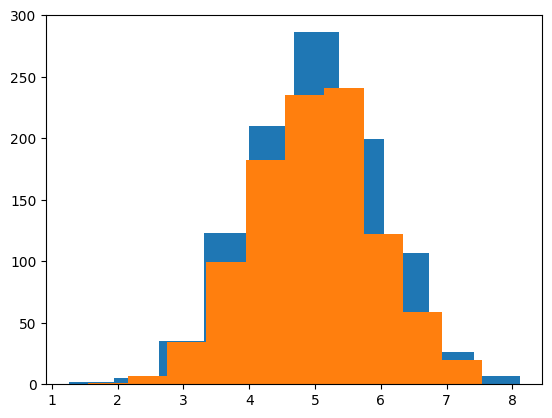

In [182]:
with torch.no_grad():
    Z = torch.normal(0,1,(1000,))    
    X = torch.normal(0,1,(1000,))    
    
    mu = model_p_mu(Z)
    log_sigma = model_p_sigma(Z)

    X = mu + log_sigma.exp()*X
plt.hist(X_og)
plt.hist(X)

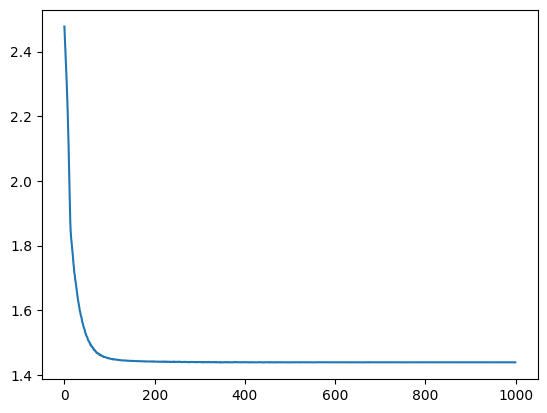

In [96]:
X_og = np.concatenate([np.random.normal(5,1,500),np.random.normal(-5,1,500)])
X = torch.tensor(X_og)




c = nn.Parameter(torch.tensor(1.0))
d = nn.Parameter(torch.tensor(1.0))
A = nn.Parameter(torch.ones(2,2,dtype=torch.double))
l=[]

class SingleN(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = nn.Parameter(torch.tensor(1.0))
        self.b = nn.Parameter(torch.tensor(1.0))
    def forward(self,x):
        return F.relu(self.a*x +self.b)

class model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers= nn.ModuleList([SingleN() for _ in range(3)])
    def forward(self,x):
        for l in self.layers:
            x += l(x)
        return x


model = SingleN()

optimiser_phi = torch.optim.Adam(model.parameters(),0.01)
optimiser_theta = torch.optim.Adam([A],0.01)


for i in range(1000):

    
    for i in range(5):
        q_bernouli = F.sigmoid(model(X))  # probablty if X is from distrubition 1 or 2
        Z = torch.bernoulli(q_bernouli.detach()) - q_bernouli.detach() + q_bernouli 
        mu_log_var_z = torch.stack([Z,1-Z],dim=1) @ A 
        loss = (mu_log_var_z[:,1] + 0.5*(X - mu_log_var_z[:,0])**2/mu_log_var_z[:,1].exp()**2)
        loss += q_bernouli * q_bernouli.log()  + (1- q_bernouli) * (1-q_bernouli).log()
        
        loss  = loss.mean()
        optimiser_phi.zero_grad()
        loss.backward()
        optimiser_phi.step()

    l.append(loss.item())

    q_bernouli = F.sigmoid(model(X))  # probablty if X is from distrubition 1 or 2
    Z = torch.bernoulli(q_bernouli.detach()) - q_bernouli.detach() + q_bernouli 
    mu_log_var_z = torch.stack([Z,1-Z],dim=1) @ A 
    loss = (mu_log_var_z[:,1] + 0.5*(X - mu_log_var_z[:,0])**2/mu_log_var_z[:,1].exp()**2)
    loss  = loss.mean()
    optimiser_theta.zero_grad()
    loss.backward()
    optimiser_theta.step()
plt.plot(l)

(array([  6.,  26.,  64., 151., 199., 231., 178.,  96.,  38.,  11.]),
 array([-15.5932442 , -12.5408968 ,  -9.4885494 ,  -6.436202  ,
         -3.3838546 ,  -0.33150719,   2.72084021,   5.77318761,
          8.82553501,  11.87788241,  14.93022981]),
 <BarContainer object of 10 artists>)

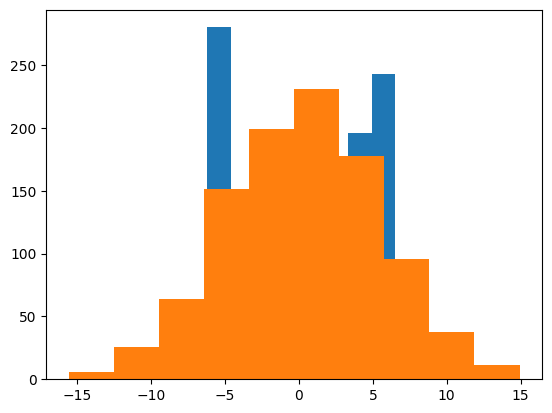

In [97]:
with torch.no_grad():
    Z = torch.bernoulli(torch.tensor([0.5 for _ in range(1000)],dtype=torch.double))
    mu_log_var_z= torch.stack([Z,1-Z],dim=1) @ A

    
    X = torch.normal(0,1,(1000,))
    X = mu_log_var_z[:,0] + mu_log_var_z[:,1].exp()*X
plt.hist(X_og)
plt.hist(X.detach().numpy())

In [98]:
A


Parameter containing:
tensor([[0.0105, 1.6329],
        [0.0036, 1.6320]], dtype=torch.float64, requires_grad=True)

(array([521.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 479.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

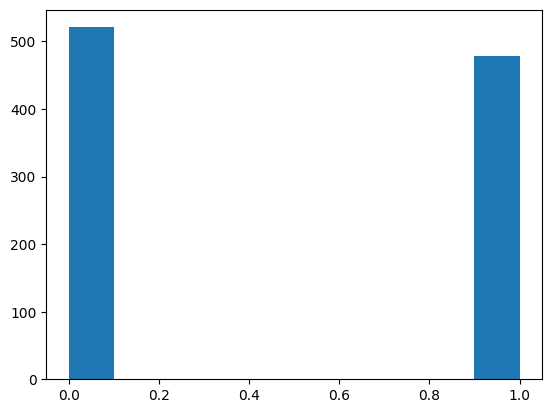

In [43]:
plt.hist(Z)